# Introduction

At its heart, parallel programming is based around techniques for splitting a problem into many smaller parts, where each part can be run at the same time in order to arrive at a final result faster than if the problem was not split. In climate and weather science parallel programming techniques can be used in both data analysis and computer modelling.

The ways a problem is split up can vary according to the task. For analysing observational data a task might be processing a single weather station, while for a model a task might be evaluating the model on a subregion of the full domain. When converting a dataset from hourly to daily frequency a task might be processing a single year of the full dataset.

Modern computers can parallelise things on a number of levels - a single CPU chip will have a number of processing 'cores', each able to run its own program independently. High end computers can have multiple CPU chips, each a 'socket', and computers can themselves be networked into a supercomputer cluster with program run on multiple 'nodes', communicating over the network using MPI.

Throughout this website I'll generically refer to 'processors', which can be read as the CPU cores being used in the parallel program, whether on the same CPU chip or distributed across a supercomputer.

While generally the programs being run are all the same with each working on part of the data, in some cases some of the programs will be different, for instance in coupled models the programs modelling the atmosphere and ocean are different, but talk to each other to share surface fluxes.

## Ahmdahl's Law

One of the most important things to remember when parallelising a task is the limitations. For a given task, adding more processors won't keep making it run faster indefinitely - there will always be parts that can't be parallised (in a model this comes from tasks like reading and writing files, or computing global statistics). As more processors are added only the parallelisable parts get quicker so past some point increasing the number of processors doesn't produce a useful effect. This is known as [Ahmdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law).

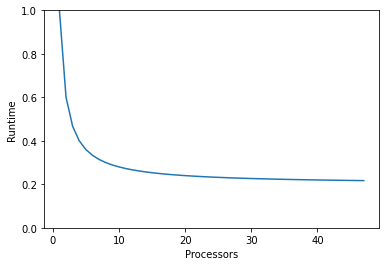

In [1]:
import matplotlib.pyplot as plt
import numpy
processors = numpy.arange(1, 48)
serial_fraction = 0.2 # 20 % serial, 80% parallelisable
runtime = serial_fraction + (1 - serial_fraction)/processors
plt.plot(processors, runtime)
plt.gca().set_ylim(0,1)
plt.xlabel('Processors')
plt.ylabel('Runtime');

There are ways to compensate for Ahmdahl's Law - you can for example use the extra processors to do more work by increasing the resolution.

Another potential problem to be aware of is that as you add more processors, the time they spend communicating with each other can become significant. Say every process needs to communicate with every other one - there is an $\mathcal{O}(n^2)$ cost from this communication. 

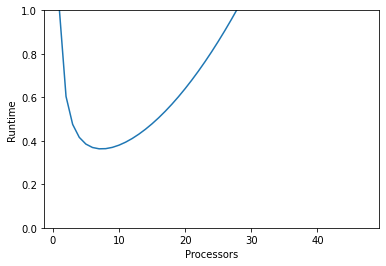

In [2]:
comms_cost = 0.001 * processors**2
runtime = serial_fraction + (1 - serial_fraction)/processors + comms_cost
plt.plot(processors, runtime)
plt.gca().set_ylim(0,1)
plt.xlabel('Processors')
plt.ylabel('Runtime');

You can see this has a dramatic effect on what processor count. In models you're unlikely to see something as costly as $\mathcal{O}(n^2)$, as processors generally only need to communicate with their neighbours, but this is still a cost to keep in mind. When determining the number of processors to use it's always best to profile, don't assume more processors will neccessarily produce results faster.



## Supercomputer Charges

Supercomputers will generally charge for resources in some manner - at NCI supercomputer time is charged in 'Service Units', or SU. Projects get an allocation of SU, either from a merit allocation scheme or through a partner share, then any supercomputer use is charged to that account.

Service Unit cost is proporional to the product of the job runtime and the number of processors - so the combined runtime for all the processors used. The specific queue and memory request then adds a multiplier to this value.

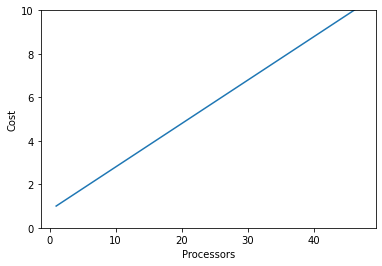

In [3]:
runtime = serial_fraction + (1 - serial_fraction)/processors
cost = runtime * processors
plt.plot(processors, cost)
plt.gca().set_ylim(0,10)
plt.xlabel('Processors')
plt.ylabel('Cost');

Users of the supercomputer are expected to use its resources efficiently, as it is a shared resource. There is a balance to be made here - more processors reduces the runtime, so you get results quicker, but can increase cost especially as you approach the speed limits from Ahmdahl's Law.

You can estimate the optimal number of processors by finding the minimum of runtime x cost, which gives a balance between fast runtime and low cost. From there you can add more processors if you need faster results at a higher cost, or if you don't need results super quickly you can lower the number of cpus for a smaller cost.

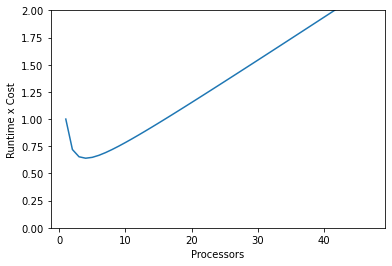

In [4]:
runtime = serial_fraction + (1 - serial_fraction)/processors
cost = runtime * processors
plt.plot(processors, runtime * cost)
plt.gca().set_ylim(0,2)
plt.xlabel('Processors')
plt.ylabel('Runtime x Cost');

In the real world you would estimate this minimum point by doing profile runs at a few different processor counts. A [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm) can be helpful - start with getting a high, middle, and low processor count runtime, then focus on the side with the lowest values, checking a processor count halfway between those.

## Profiling Scaling

In order to tell where you are on the Ahmdahl's Law curve it's essential to profile your work - especially if your program will be using a lot of processors or running for a long time. The profilling only needs to be basic - generally just working out the runtime for a small subset of the total work, and extrapolating from that to work out what the full cost would be.

In modelling, this profiling is generally done by reducing the time domain of a model. Rather than running the model for a full year you only run it for a few days. For data analysis, you might try running it on a representative sample - say a couple years out of a reanalysis that you intend to process fully.

Keep a record of the time taken for different processor counts, from which you can calculate the total time you expect it to take for the full run. If you are charged for computer time also keep a record of the cost for each processor count.

In [5]:
import pandas, io
record = """
processors, walltime (s), cost (ksu)
        96,          182,         35
       144,          136,         39
       192,          113,         43
       240,          104,         50
"""
data = pandas.read_csv(io.StringIO(record), skipinitialspace=True)
data

,processors,walltime (s),cost (ksu)
0,96,182,35
1,144,136,39
2,192,113,43
3,240,104,50


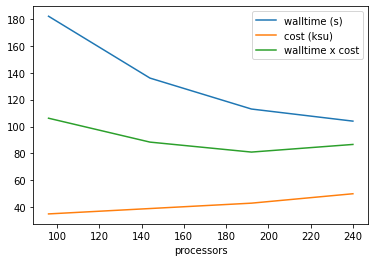

In [9]:
data['walltime x cost'] = data['walltime (s)'] * data['cost (ksu)'] / 60 # Scaled to fit on the plot

ax = plt.axes()
data.plot('processors', 'walltime (s)', ax=ax)
data.plot('processors', 'cost (ksu)', ax=ax)
data.plot('processors', 'walltime x cost', ax=ax);

Here the optimised cost x walltime is at 192 processors. If this was a 10 day sample, then a full year would be

In [8]:
data.iloc[[2]][['walltime (s)', 'cost (ksu)']] * 365 / 10

,walltime (s),cost (ksu)
2,4124.5,1569.5


When making a merit allocation request for supercomputer time at NCI this is the scaling information that they are looking for.